In [1]:
# Bayesian Optimization: A Water Potability

In [2]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/fenago/datasets/main/water_potability.csv"
water_data = pd.read_csv(url)

# Display dataset info
print(water_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


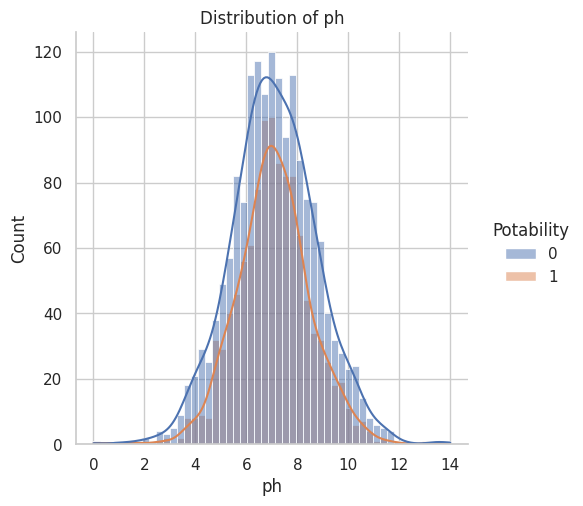

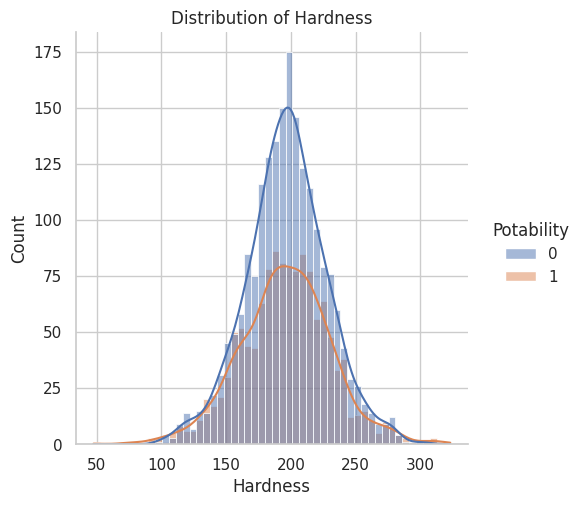

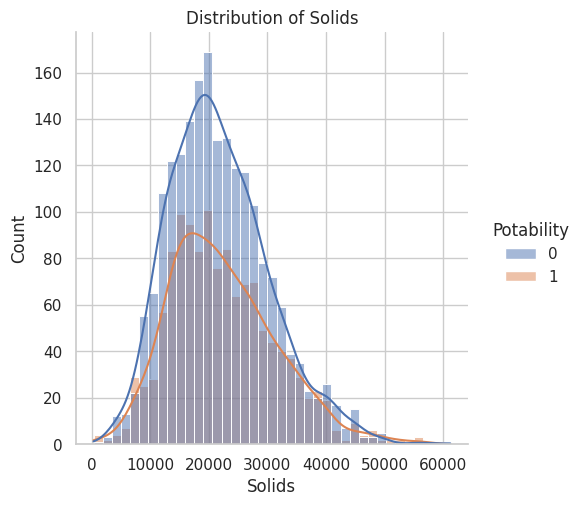

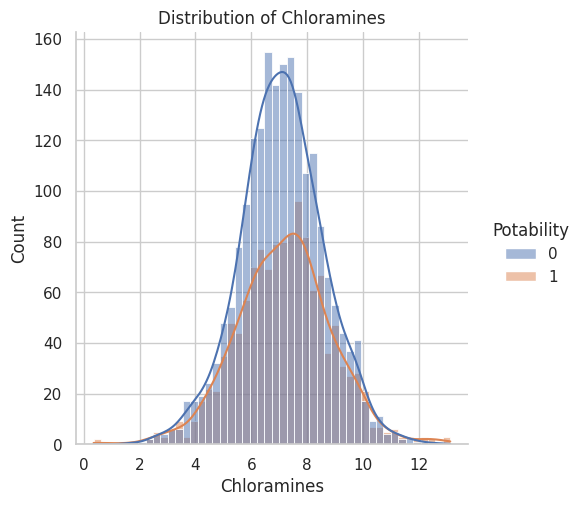

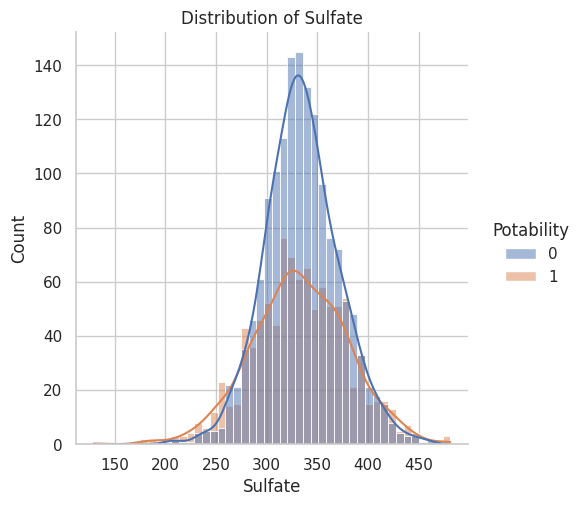

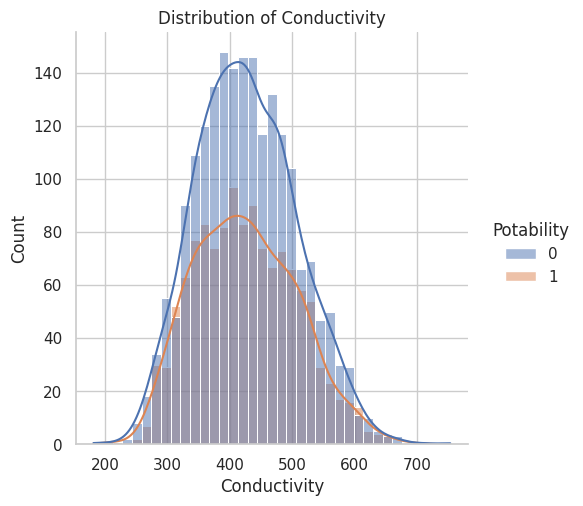

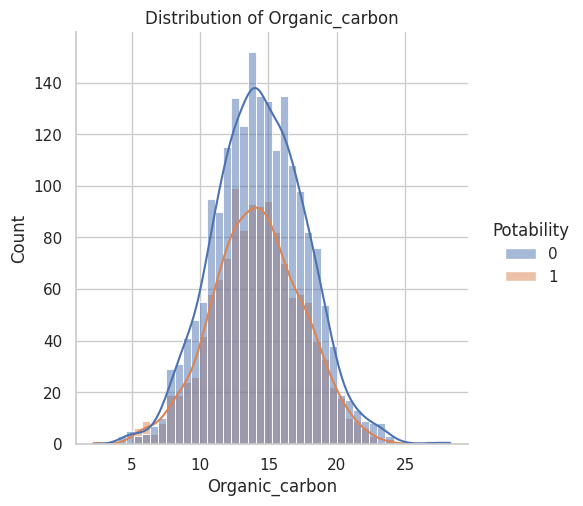

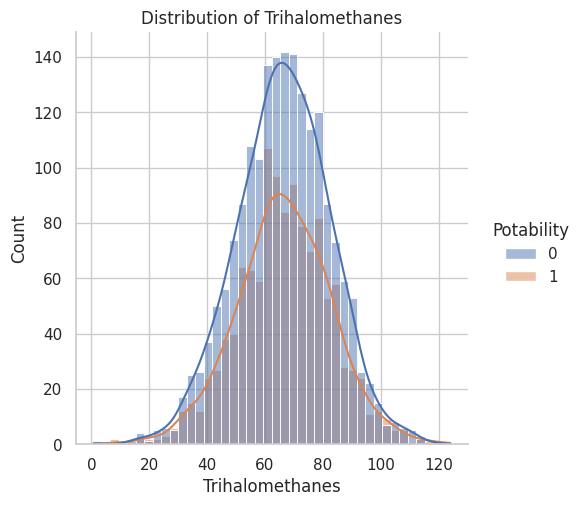

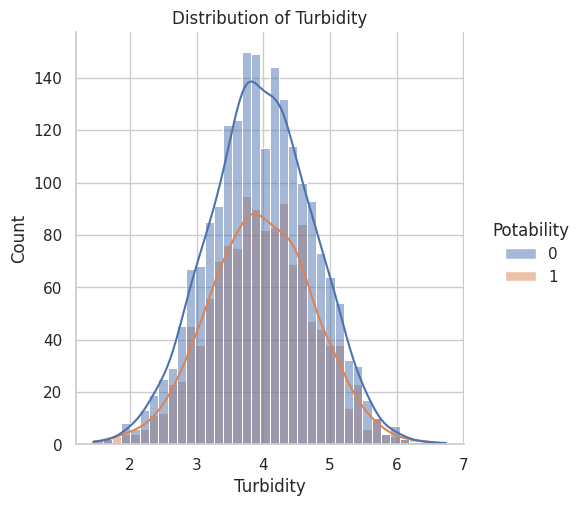

In [3]:
# Visualize feature distributions
sns.set(style="whitegrid")
for col in water_data.columns[:-1]:
    sns.displot(data=water_data, x=col, hue="Potability", kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [4]:
!pip install bayesian-optimization


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Handle missing values
water_data.fillna(water_data.mean(), inplace=True)

# Split the dataset into training and test sets
X = water_data.drop("Potability", axis=1)
y = water_data["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define function to compute cross-validated accuracy
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample):
    model = xgb.XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        random_state=42,
    )
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))

# Define function to optimize XGBoost classifier using Bayesian Optimization
def optimize_xgb():
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample)

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (100, 500),
            "max_depth": (3, 10),
            "gamma": (0, 1),
            "min_child_weight": (1, 10),
            "subsample": (0.5, 1),
        },
        random_state=42,
    )
    optimizer.maximize(n_iter=10)
    return optimizer.max

# Find optimal hyperparameters using Bayesian Optimization
best_params = optimize_xgb()['params']
print("Best hyperparameters found by Bayesian Optimization:", best_params)

# Train the XGBoost classifier with the best hyperparameters
best_xgb = xgb.XGBClassifier(
    n_estimators=int(best_params["n_estimators"]),
    max_depth=int(best_params["max_depth"]),
    gamma=best_params["gamma"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    random_state=42,
)

best_xgb.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])

print("Test set accuracy with best hyperparameters:", accuracy)
print("Test set F1-score with best hyperparameters:", f1)
print("Test set ROC-AUC score with best hyperparameters:", roc_auc)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.6221    | 0.3745    | 9.655     | 7.588     | 339.5     | 0.578     |
| 2         | 0.6263    | 0.156     | 3.407     | 8.796     | 340.4     | 0.854     |
| 3         | 0.6298    | 0.02058   | 9.789     | 8.492     | 184.9     | 0.5909    |
| 4         | 0.6252    | 0.1834    | 5.13      | 5.723     | 272.8     | 0.6456    |
| 5         | 0.6366    | 0.6119    | 3.976     | 3.629     | 246.5     | 0.728     |
| 6         | 0.6233    | 0.2365    | 4.861     | 2.988     | 240.0     | 0.9024    |
| 7         | 0.6244    | 0.5204    | 4.412     | 4.752     | 348.7     | 0.9409    |
| 8         | 0.6302    | 0.1604    | 9.344     | 9.601     | 205.9     | 0.8083    |
| 9         | 0.6321    | 0.158     | 3.873     | 8.194     | 138.4     | 0.7529    |
| 10        | 0.6534    | 0.8466    | 6.231     | 1.55

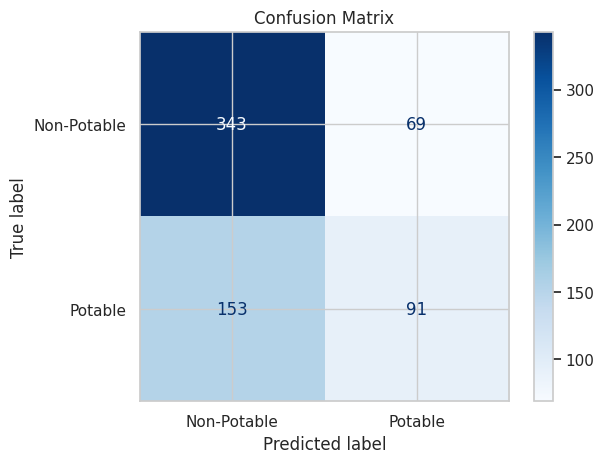

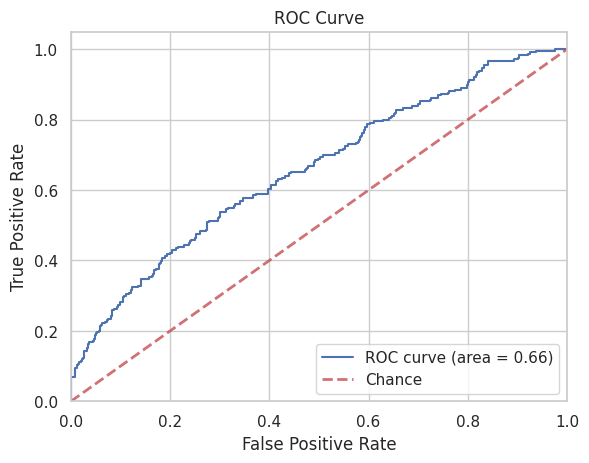

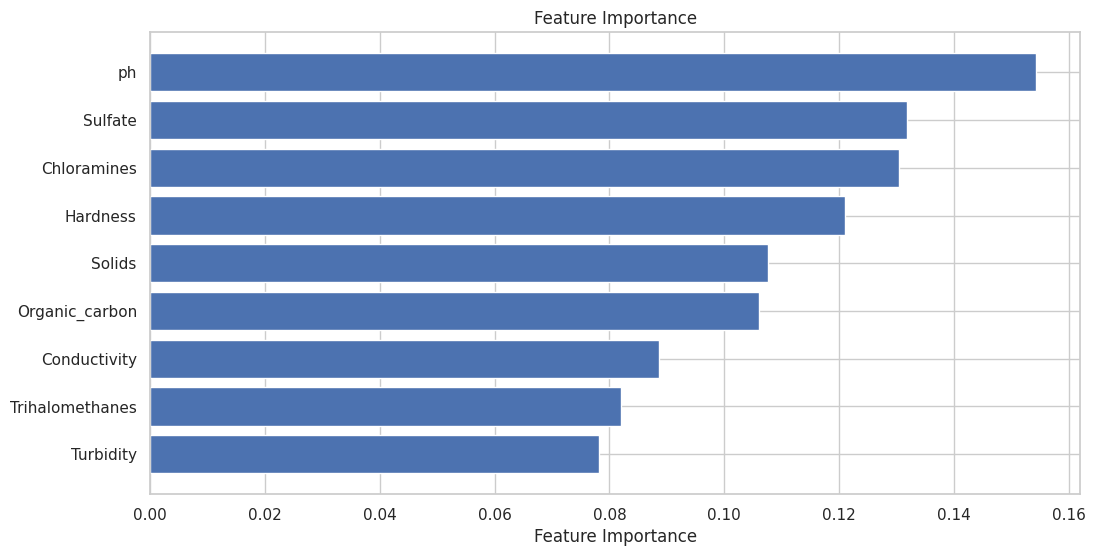

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Potable", "Potable"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Feature Importance Plot with actual feature names
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.show()